## Parte 2: Configuración Avanzada

Aquí se importan las bibliotecas necesarias para la parte avanzada de la configuración. Estas incluyen TensorFlow para manejar la red neuronal, scikit-learn para la manipulación de datos y evaluación de modelos, NumPy para operaciones numéricas, Matplotlib para visualización y algunas herramientas adicionales. En la parte del PATH se establece el entorno de trabajo para que TensorFlow y otras herramientas puedan acceder a los ejecutables necesarios, como los de Xilinx Vivado.# Part 2: Advanced Configuration

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import plotting
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

2024-05-28 02:16:01.877425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 02:16:01.968335: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Cargar dataset
Aquí se cargan los conjuntos de datos previamente guardados en archivos numpy.
X_train_val y X_test contienen las características de entrenamiento y prueba respectivamente, mientras que y_train_val y y_test contienen las etiquetas correspondientes. classes almacena las clases objetivo del modelo.

In [2]:
X_train_val = np.load('X_train_val.npy')
X_test = np.ascontiguousarray(np.load('X_test.npy'))
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy', allow_pickle=True)
classes = np.load('classes.npy', allow_pickle=True)

## Cargar el modelo
Aquí se carga el modelo previamente entrenado en la parte 1, asegúrate de haber completado esa parte antes de cargar el modelo.
Este código carga el modelo guardado en el archivo 'model_1/KERAS_check_best_model.h5' y luego utiliza el modelo para hacer predicciones en el conjunto de datos de prueba X_test. Las predicciones se almacenan en la variable y_keras.

In [3]:
from tensorflow.keras.models import load_model

model = load_model('model_1/KERAS_check_best_model.h5')
y_keras = model.predict(X_test)

2024-05-28 02:16:06.430113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 103ms/step


## Configuración y modelo hls4ml
Aquí creamos una configuración más detallada para el modelo. Al imprimir el diccionario de configuración, notarás que se crea una entrada para cada capa nombrada del modelo. Por ejemplo, para la primera capa:
```LayerName:
    fc1:
        Precision:
            weight: ap_fixed<16,6>
            bias:   ap_fixed<16,6>
            result: ap_fixed<16,6>
        ReuseFactor: 1
```
Tomando esta configuración "tal como está", todos los parámetros se establecerán con los mismos valores que en la parte 1, pero podemos usarla como plantilla para comenzar a modificar cosas.
Este código crea una configuración detallada del modelo utilizando la función config_from_keras_model de hls4ml, especificando que queremos granularidad por nombre de capa. Luego imprimimos esta configuración para revisarla y ver cómo se establecen los parámetros para cada capa nombrada del modelo.

In [4]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")

Interpreting Sequential
Topology:
Layer name: input_3, layer type: InputLayer, input shapes: [[None, 60, 60]], output shape: [None, 60, 60]
Layer name: flatten_2, layer type: Reshape, input shapes: [[None, 60, 60]], output shape: [None, 3600]
Layer name: dense_4, layer type: Dense, input shapes: [[None, 3600]], output shape: [None, 128]
Layer name: dense_5, layer type: Dense, input shapes: [[None, 128]], output shape: [None, 2]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  input_3
    Trace:           False
    Precision
      result:        fixed<16,6>
  flatten_2
    Trace:           False
    Precision
      result:        fixed<16,6>
  dense_4
    Trace:           False
    Precision
      result:        fixed<16,6>
      weight:        fixed<16,6>
      bias:          fixed<16,6>
  dense_4_relu
    Trace:           False
    Precis

## Perfilado
Como puedes ver, podemos elegir la precisión de todo en nuestra red neuronal. Esta es una forma poderosa de ajustar el rendimiento, pero también es complicada. Las herramientas en hls4ml.model.profiling pueden ayudarte a elegir la precisión correcta para tu modelo. (Dicho esto, entrenar tu modelo con cuantificación integrada puede resolver este problema, y eso se introduce en la Parte 4. Entonces, no profundices demasiado en la sintonización de tus tipos de datos sin antes probar el entrenamiento con cuantificación consciente con QKeras).

Lo primero que debes intentar es perfilar numéricamente tu modelo. Este método traza la distribución de los pesos (y sesgos) como un diagrama de caja y bigotes. Las cajas grises muestran los valores que se pueden representar con los tipos de datos utilizados en el hls_model. Por lo general, necesitas que la caja se solape completamente con el bigote 'hacia la derecha' (valores grandes), de lo contrario, tendrás problemas de saturación y desbordamiento. Puede estar bien que la caja no se solape completamente 'hacia la izquierda' (valores pequeños), pero encontrar qué tan pequeño puedes ir es cuestión de prueba y error..

Proporcionar datos, en este caso, solo usando los primeros 1000 ejemplos para mayor rapidez, mostrará las mismas distribuciones capturadas en la salida de cada capa.

Interpreting Sequential
Topology:
Layer name: input_3, layer type: InputLayer, input shapes: [[None, 60, 60]], output shape: [None, 60, 60]
Layer name: flatten_2, layer type: Reshape, input shapes: [[None, 60, 60]], output shape: [None, 3600]
Layer name: dense_4, layer type: Dense, input shapes: [[None, 3600]], output shape: [None, 128]
Layer name: dense_5, layer type: Dense, input shapes: [[None, 128]], output shape: [None, 2]
Creating HLS model
Interpreting Sequential
Topology:
Layer name: input_3, layer type: InputLayer, input shapes: [[None, 60, 60]], output shape: [None, 60, 60]
Layer name: flatten_2, layer type: Reshape, input shapes: [[None, 60, 60]], output shape: [None, 3600]
Layer name: dense_4, layer type: Dense, input shapes: [[None, 3600]], output shape: [None, 128]
Layer name: dense_5, layer type: Dense, input shapes: [[None, 128]], output shape: [None, 2]
Creating HLS model
Profiling weights (before optimization)
Profiling weights (final / after optimization)
Profiling a

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>)

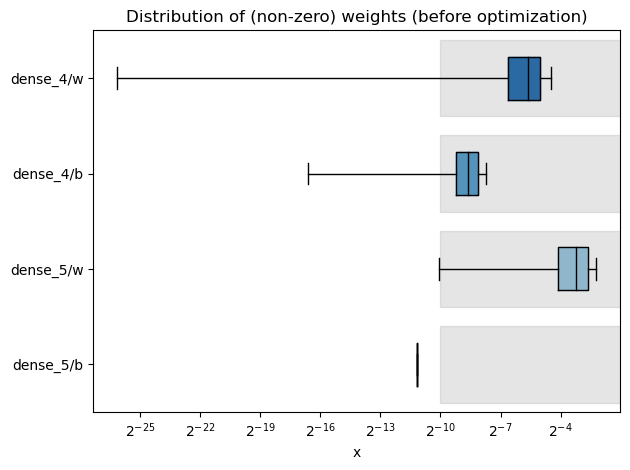

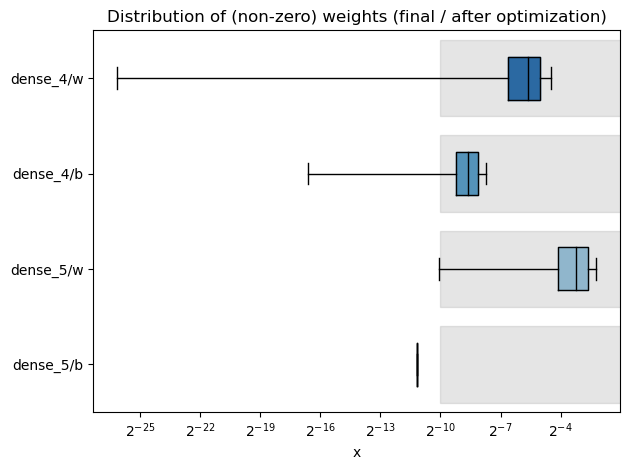

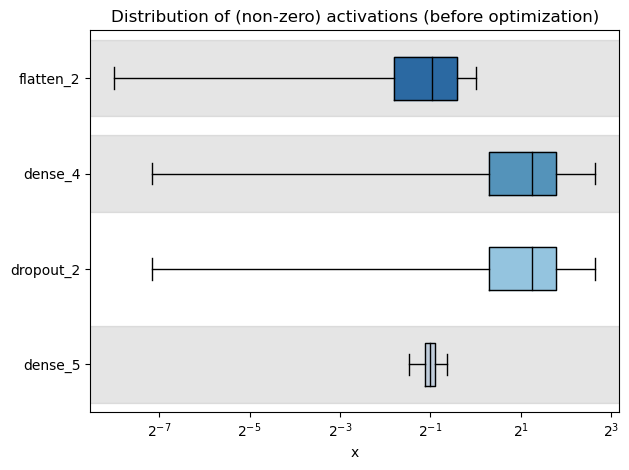

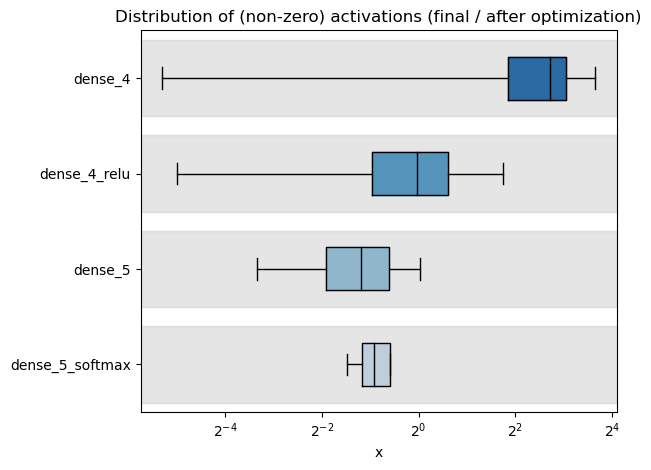

In [5]:
%matplotlib inline
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj_2', part='xcu250-figd2104-2L-e'
)
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=X_test[:1000])

## Personalización
Intentemos establecer la precisión de los pesos de la primera capa en algo más estrecho que 16 bits. Usar menos bits puede ahorrar recursos en la FPGA. Después de inspeccionar la gráfica de perfilado anterior, intentemos con 8 bits con 1 bit entero.

Luego, crearemos un nuevo modelo HLS y mostraremos el perfilado con la nueva configuración. Esta vez, solo mostraremos el perfil de los pesos al no proporcionar ningún dato 'X'. Después, crearemos el modelo HLS y mostraremos la arquitectura. Observa que la caja alrededor de los pesos de la primera capa refleja la precisión diferente.

Interpreting Sequential
Topology:
Layer name: input_3, layer type: InputLayer, input shapes: [[None, 60, 60]], output shape: [None, 60, 60]
Layer name: flatten_2, layer type: Reshape, input shapes: [[None, 60, 60]], output shape: [None, 3600]
Layer name: dense_4, layer type: Dense, input shapes: [[None, 3600]], output shape: [None, 128]
Layer name: dense_5, layer type: Dense, input shapes: [[None, 128]], output shape: [None, 2]
Creating HLS model
Interpreting Sequential
Topology:
Layer name: input_3, layer type: InputLayer, input shapes: [[None, 60, 60]], output shape: [None, 60, 60]
Layer name: flatten_2, layer type: Reshape, input shapes: [[None, 60, 60]], output shape: [None, 3600]
Layer name: dense_4, layer type: Dense, input shapes: [[None, 3600]], output shape: [None, 128]
Layer name: dense_5, layer type: Dense, input shapes: [[None, 128]], output shape: [None, 2]
Creating HLS model
Profiling weights (before optimization)
Profiling weights (final / after optimization)


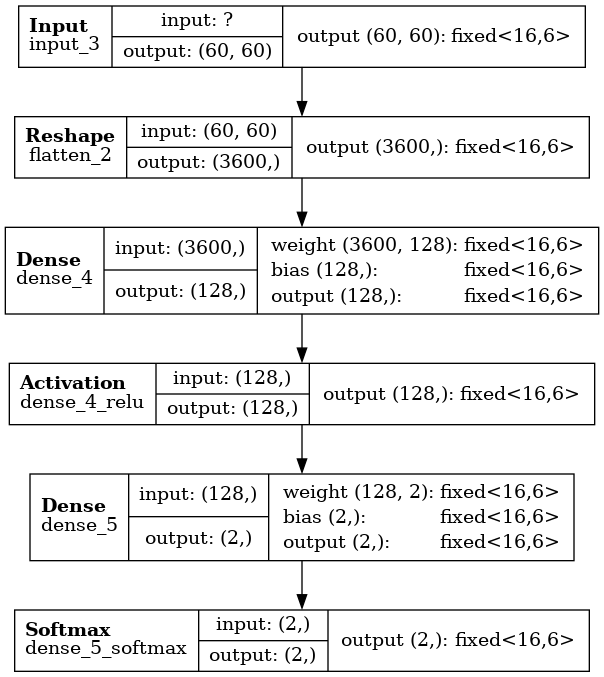

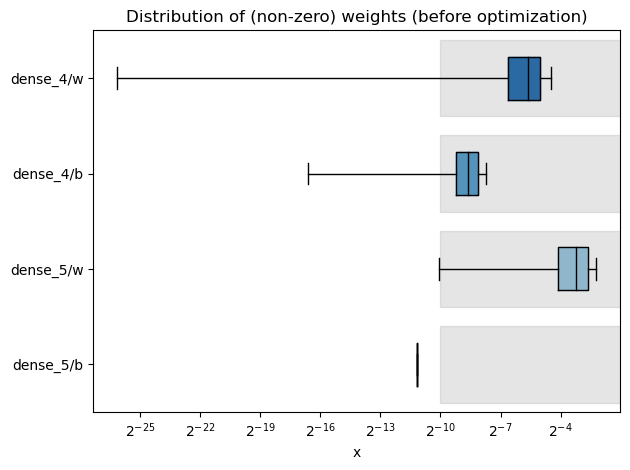

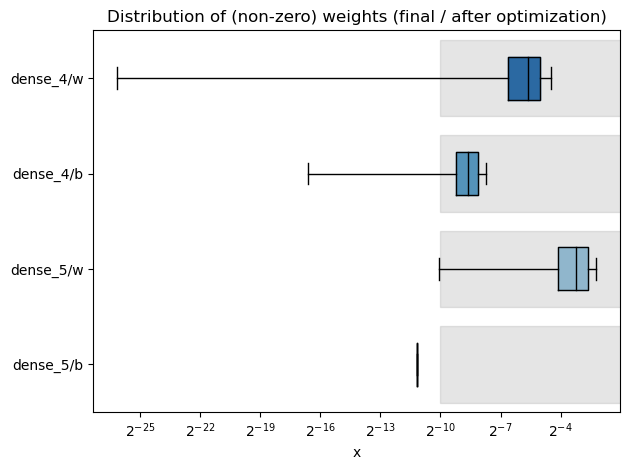

In [6]:
config['LayerName']['input_3']['Precision']['weight'] = 'ap_fixed<8,2>'
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj_2', part='xcu250-figd2104-2L-e'
)
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model)
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Rastreo
Cuando comenzamos a utilizar precisión personalizada en todo el modelo, puede ser útil recopilar la salida de cada capa para averiguar cuándo las cosas han salido mal. Habilitamos esta recopilación de rastreo configurando Trace = True para cada capa cuya salida queremos recopilar.

In [7]:
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj_2', part='xcu250-figd2104-2L-e'
)

Interpreting Sequential
Topology:
Layer name: input_3, layer type: InputLayer, input shapes: [[None, 60, 60]], output shape: [None, 60, 60]
Layer name: flatten_2, layer type: Reshape, input shapes: [[None, 60, 60]], output shape: [None, 3600]
Layer name: dense_4, layer type: Dense, input shapes: [[None, 3600]], output shape: [None, 128]
Layer name: dense_5, layer type: Dense, input shapes: [[None, 128]], output shape: [None, 2]
Creating HLS model


## Compilación, rastreo, predicción
Ahora necesitamos verificar que el rendimiento de este modelo siga siendo bueno después de reducir la precisión. Compilamos el hls_model y ahora usamos el método hls_model.trace para recopilar la salida del modelo, y también la salida de todas las capas para las que habilitamos el rastreo. Esto devuelve un diccionario con claves que corresponden a los nombres de las capas del modelo. Almacenado en esa clave está la matriz de valores producidos por esa capa, muestreada de los datos proporcionados. Una función auxiliar get_ymodel_keras devolverá el mismo diccionario para el modelo de Keras.

Solo ejecutaremos el rastreo para los primeros 1000 ejemplos, ya que lleva un poco más de tiempo y utiliza más memoria que simplemente ejecutar la predicción.

In [8]:
hls_model.compile()
hls4ml_pred, hls4ml_trace = hls_model.trace(X_test[:1000])
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test[:1000])
y_hls = hls_model.predict(X_test)

Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
1/1 [==============================] - 0s 41ms/step
Done taking outputs for Keras model.


## Inspección
Ahora podemos imprimir, hacer gráficos o realizar cualquier otro análisis más detallado sobre la salida de cada capa para asegurarnos de que no hemos empeorado el rendimiento. Y si lo hemos hecho, podemos encontrar rápidamente dónde. Simplemente imprimiremos la salida de la primera capa, para el primer ejemplo, tanto para los modelos de Keras como para hls4ml.

In [9]:
print("Keras layer 'input_3', first sample:")
print(keras_trace,['input_3'][0])
print("hls4ml layer 'input_3', first sample:")
print(hls4ml_trace,['input_3'][0])

Keras layer 'input_3', first sample:
{'dense_4': array([[-7.434631 , -2.842122 , -1.5033387, ..., -3.8982766, -3.2140415,
        -7.2154965],
       [-6.6426034, -2.471508 , -1.7564226, ..., -2.7543352, -2.8807523,
        -6.529959 ],
       [-5.5082636, -2.515239 , -1.6674827, ..., -3.5195749, -2.0399404,
        -5.8366838],
       ...,
       [-5.1962676, -2.4035113, -1.7921472, ..., -2.135521 , -2.381734 ,
        -5.158257 ],
       [-5.0544786, -1.7552991, -1.0201573, ..., -2.487446 , -2.1755657,
        -4.7850327],
       [-4.373763 , -1.7491884, -1.3298383, ..., -2.190917 , -1.6494123,
        -4.4841657]], dtype=float32), 'dense_5': array([[-1.7577759 , -1.2826402 ],
       [-1.3208537 , -1.2217274 ],
       [-1.551173  , -0.96819186],
       [-1.3164334 , -1.4569075 ],
       [-1.0699496 , -0.94270074],
       [-1.2583697 , -1.0491284 ],
       [-0.7395563 , -1.0241365 ],
       [-0.80379844, -0.8164965 ]], dtype=float32), 'flatten_2': array([[0.91764706, 0.9137255 , 0.909

## Comparación
Comparemos si perdimos rendimiento al usar 8 bits para los pesos de la primera capa, inspeccionando la precisión y la curva ROC.

In [11]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

Keras  Accuracy: 1.0
hls4ml Accuracy: 0.625


## Resumen de Profiling & Trace
Perdimos una pequeña cantidad de precisión en comparación con cuando usamos ap_fixed<16,6>, pero en muchos casos esta diferencia será lo suficientemente pequeña como para que valga la pena el ahorro de recursos. Puedes elegir qué tan agresivo ser con la cuantificación, pero siempre es sensato hacer los gráficos de perfil incluso con la configuración predeterminada. El rastreo a nivel de capa es muy útil para encontrar cuándo redujiste demasiado la anchura de bits o cuando la configuración predeterminada no es buena para tu modelo.

Con esta "cuantificación después del entrenamiento", alrededor de 8 bits de ancho generalmente parece ser el límite hasta el cual puedes ir antes de sufrir una pérdida significativa de rendimiento. En la Parte 4, veremos cómo usar la "cuantificación consciente del entrenamiento" con QKeras para reducir mucho más sin perder mucho rendimiento.

## ReuseFactor
Ahora veamos el otro parámetro de configuración: ReuseFactor. Recuerda que ReuseFactor es nuestro mecanismo para ajustar el paralelismo:

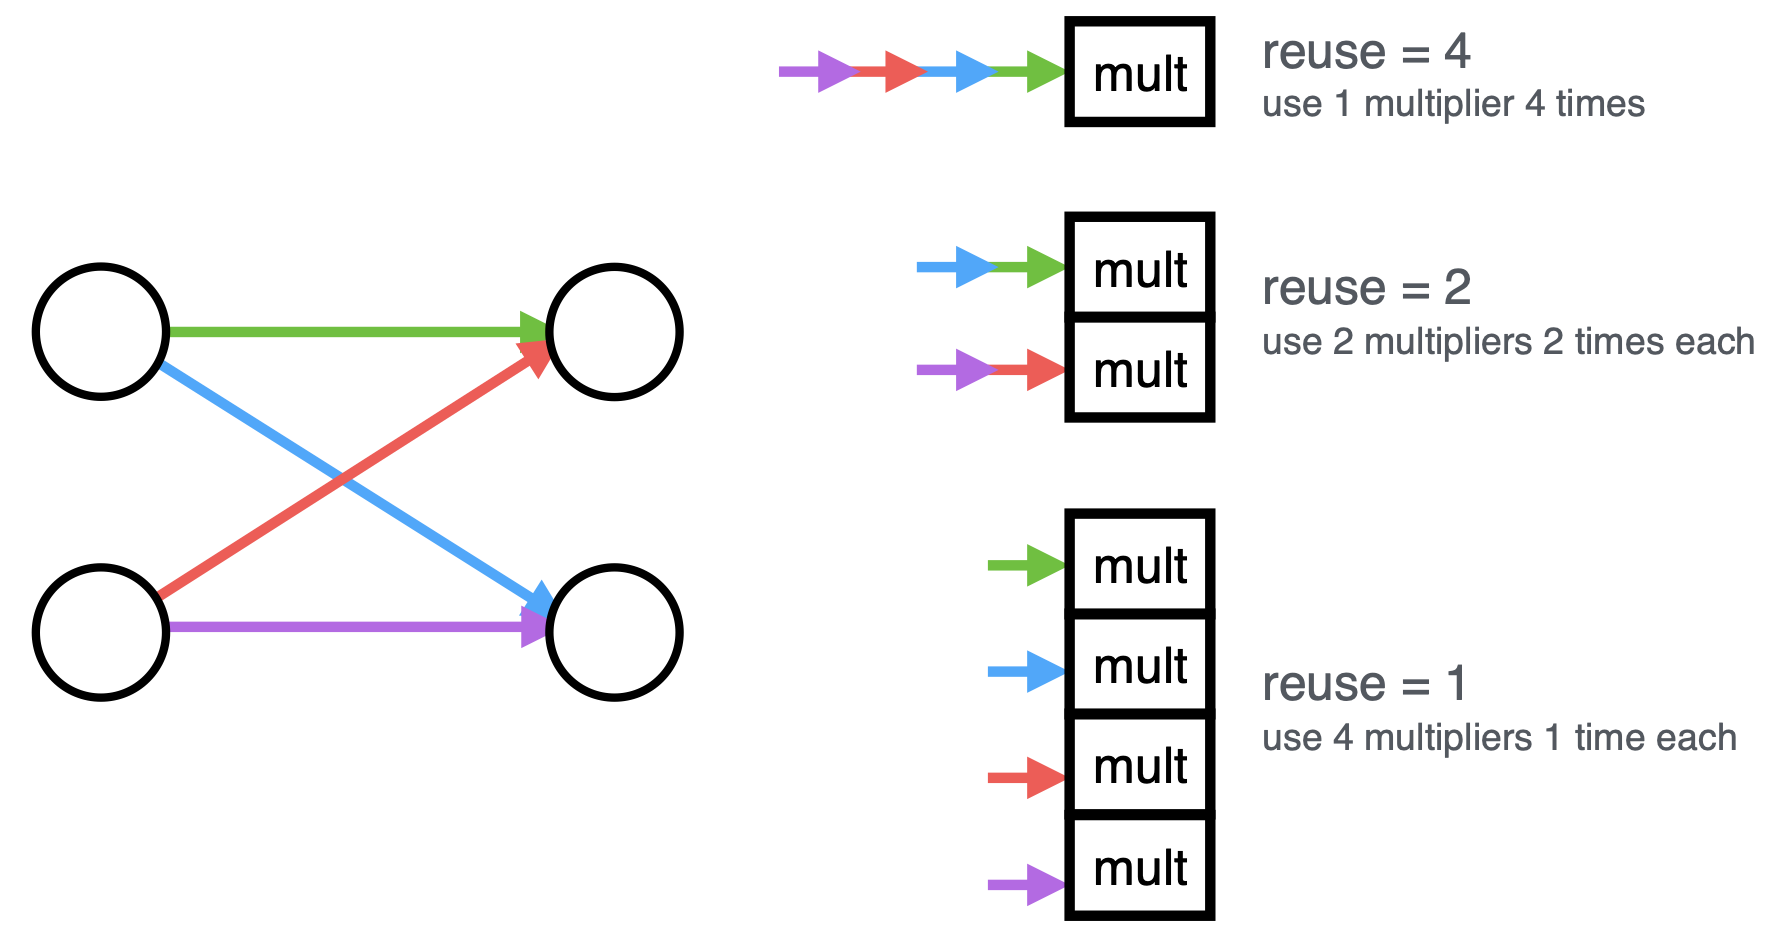

Entonces, ahora hagamos una nueva configuración para este modelo y establezcamos el ReuseFactor en 2 para cada capa: compilaremos el modelo y luego evaluaremos su rendimiento. (Nota: al crear una nueva configuración con granularidad=Modelo, estamos restableciendo implícitamente la precisión a ap_fixed<16,6> en todo el modelo). Cambiar el ReuseFactor no debería cambiar los resultados de clasificación, pero verifiquemos eso inspeccionando la precisión y la curva ROC nuevamente. Luego, construiremos el modelo.

Interpreting Sequential
Topology:
Layer name: input_3, layer type: InputLayer, input shapes: [[None, 60, 60]], output shape: [None, 60, 60]
Layer name: flatten_2, layer type: Reshape, input shapes: [[None, 60, 60]], output shape: [None, 3600]
Layer name: dense_4, layer type: Dense, input shapes: [[None, 3600]], output shape: [None, 128]
Layer name: dense_5, layer type: Dense, input shapes: [[None, 128]], output shape: [None, 2]
-----------------------------------
{'Model': {'Precision': 'fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'BramFactor': 1000000000, 'TraceOutput': False}}
-----------------------------------
Interpreting Sequential
Topology:
Layer name: input_3, layer type: InputLayer, input shapes: [[None, 60, 60]], output shape: [None, 60, 60]
Layer name: flatten_2, layer type: Reshape, input shapes: [[None, 60, 60]], output shape: [None, 3600]
Layer name: dense_4, layer type: Dense, input shapes: [[None, 3600]], output shape: [None, 128]
Layer name: dense_5, layer t

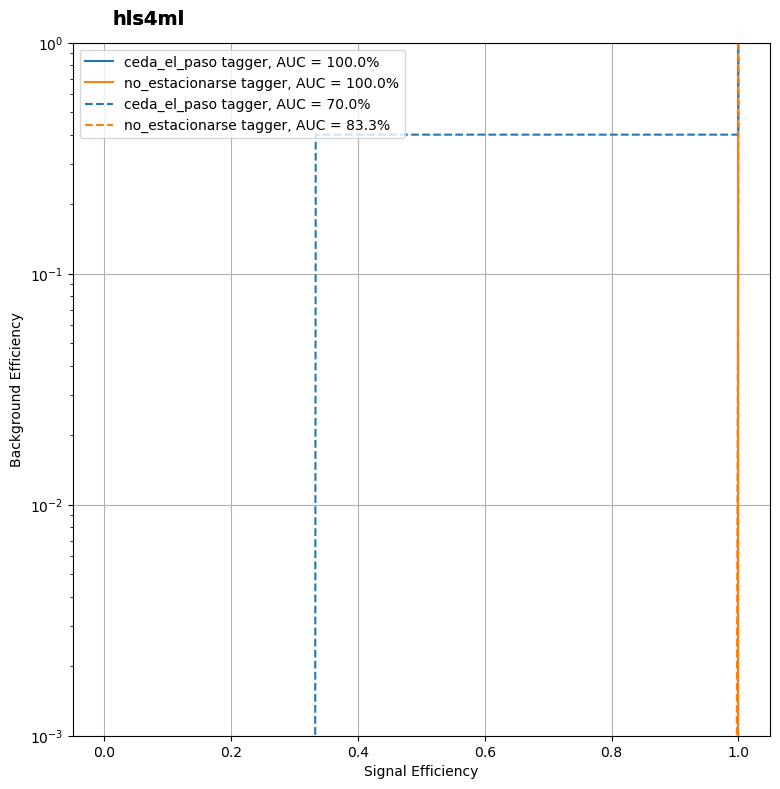

In [12]:
config = hls4ml.utils.config_from_keras_model(model, granularity='Model')
print("-----------------------------------")
print(config)
print("-----------------------------------")
# Set the ReuseFactor to 2 throughout
config['Model']['ReuseFactor'] = 2
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj_2', part='xcu250-figd2104-2L-e'
)
hls_model.compile()
y_hls = hls_model.predict(X_test)
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle='--')

Ahora vamos a construir el modelo.

Esto puede tomar varios minutos.

Mientras la síntesis C está en ejecución, podemos monitorear el progreso mirando el archivo de registro abriendo un terminal desde la carpeta del cuaderno y ejecutando:

`tail -f model_1/hls4ml_prj_2/vivado_hls.log`

In [13]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /opt/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'jovyan' on host 'e0373710e214' (Linux_x86_64 version 6.5.0-35-generic) on Tue May 28 02:17:45 UTC 2024
INFO: [HLS 200-10] In directory '/home/jovyan/HLS4ML/model_1/hls4ml_prj_2'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/jovyan/HLS4ML/model_1/hls4ml_prj_2/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'myproject_test.cpp' to the project
INFO: [HLS 200-10] Adding

{}

Ahora imprimimos el informe y lo comparamos con el informe del Ejercicio 1.

In [14]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj_2')

Found 1 solution(s) in model_1/hls4ml_prj_2/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
Synthesis report not found.
Co-simulation report not found.


In [15]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')

Found 1 solution(s) in model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
Synthesis report not found.
Co-simulation report not found.


## Exercise
- Recuerda el resultado del ejercicio de la parte 1 donde estimamos cuántos DSP debería usar nuestra red. ¿Cómo cambia esto ahora que hemos usado ReuseFactor = 2 para la red? ¿Coincide la expectativa con el informe esta vez?